# Load data

In [72]:
%reload_ext autoreload
%autoreload 2

In [73]:
from result_saver import SaverProvider
provider = SaverProvider()

In [60]:
import numpy as np
from Scratch import metadata_loader

md = metadata_loader(_extract=True, _drop_inutile=True)
md = md[md["job_status"] == "JobStatus.DONE"]
md = md[md["notebook_name"] == "bigger_rep_codes"]
max_distance = int(max(md.distance))
max_distance = 30
md = md[md["distance"] == max_distance]
md = md.sort_values(by='backend_name', ascending=False)

md = md[:2]

md

,creation_date,notebook_name,backend_name,job_id,tags,shots,tags_xp,sampled_state,num_qubits,job_status,extra,optimization_level,code,distance,rounds,logical,layout,descr
258,2023-10-30 09:45:17.340386+01:00,bigger_rep_codes,ibm_sherbrooke,cmzpt78vcq70008qf1ag,[],1111.0,NaN,NaN,NaN,JobStatus.DONE,NaN,NaN,RepetitionCodeCircuit,30.0,30,0,_is_hex=True,Run bigger Repetition codes v4: new distances ...
76,2023-10-29 14:47:58.814875+01:00,bigger_rep_codes,ibm_sherbrooke,cmz653m3r3vg008wf9j0,[],1111.0,NaN,NaN,NaN,JobStatus.DONE,NaN,NaN,RepetitionCodeCircuit,30.0,30,1,_is_hex=True,Run bigger Repetition codes


In [57]:
memories = {}
for job_id, logical in zip(md.job_id, md.logical):
    mmr_name = f"mmr_log_{logical}"
    memories[mmr_name] = provider.retrieve_job(job_id).result().get_memory()

memories

{'mmr_log_0': array([[-8.77017900e+06+1.50200610e+07j, -8.11703550e+07+8.83844170e+07j,
         -8.90356470e+07-6.99270350e+07j, ...,
          4.53259100e+06-6.92480000e+06j,  6.53649100e+06-1.01582320e+07j,
         -7.04375500e+06-1.25252570e+07j],
        [-1.60636160e+07+1.78160650e+07j, -5.54254900e+07+7.78086230e+07j,
         -7.80189140e+07-9.19035510e+07j, ...,
          5.94892000e+06-8.64211000e+06j, -5.15659700e+06-8.53124400e+06j,
         -7.61528900e+06-7.35701200e+06j],
        [-1.53899420e+07+1.84931980e+07j, -6.38122750e+07+5.13108880e+07j,
         -7.23995490e+07-6.65688640e+07j, ...,
         -6.02728800e+06-7.26816800e+06j,  4.17268100e+06-8.22921200e+06j,
          9.77587000e+06-8.86440300e+06j],
        ...,
        [ 2.99861200e+06+1.82650750e+07j, -6.42859100e+07+7.16069900e+07j,
         -1.03502149e+08-1.04476468e+08j, ...,
         -6.70937700e+06-7.63158100e+06j, -6.99002400e+06-8.77952800e+06j,
          2.65958500e+06-5.06857500e+06j],
        [-9.30

# Decode

In [63]:
import numpy as np
import stim
import pymatching

from soft_info import get_repcode_layout, get_KDEs, draw_matching_graph

# Code parameters
d=max_distance
T=max_distance
layout = get_repcode_layout(distance=max_distance, backend=provider.get_backend("ibm_sherbrooke"), _is_hex=True)

kde_dict, scaler_dict = get_KDEs(provider, 'ibm_sherbrooke', layout, bandwidths=0.2, plot=False)

circuit = stim.Circuit.generated("repetition_code:memory",
                                 distance=d,
                                 rounds=T,
                                 after_clifford_depolarization=0.1)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

memory = memories['mmr_log_1']

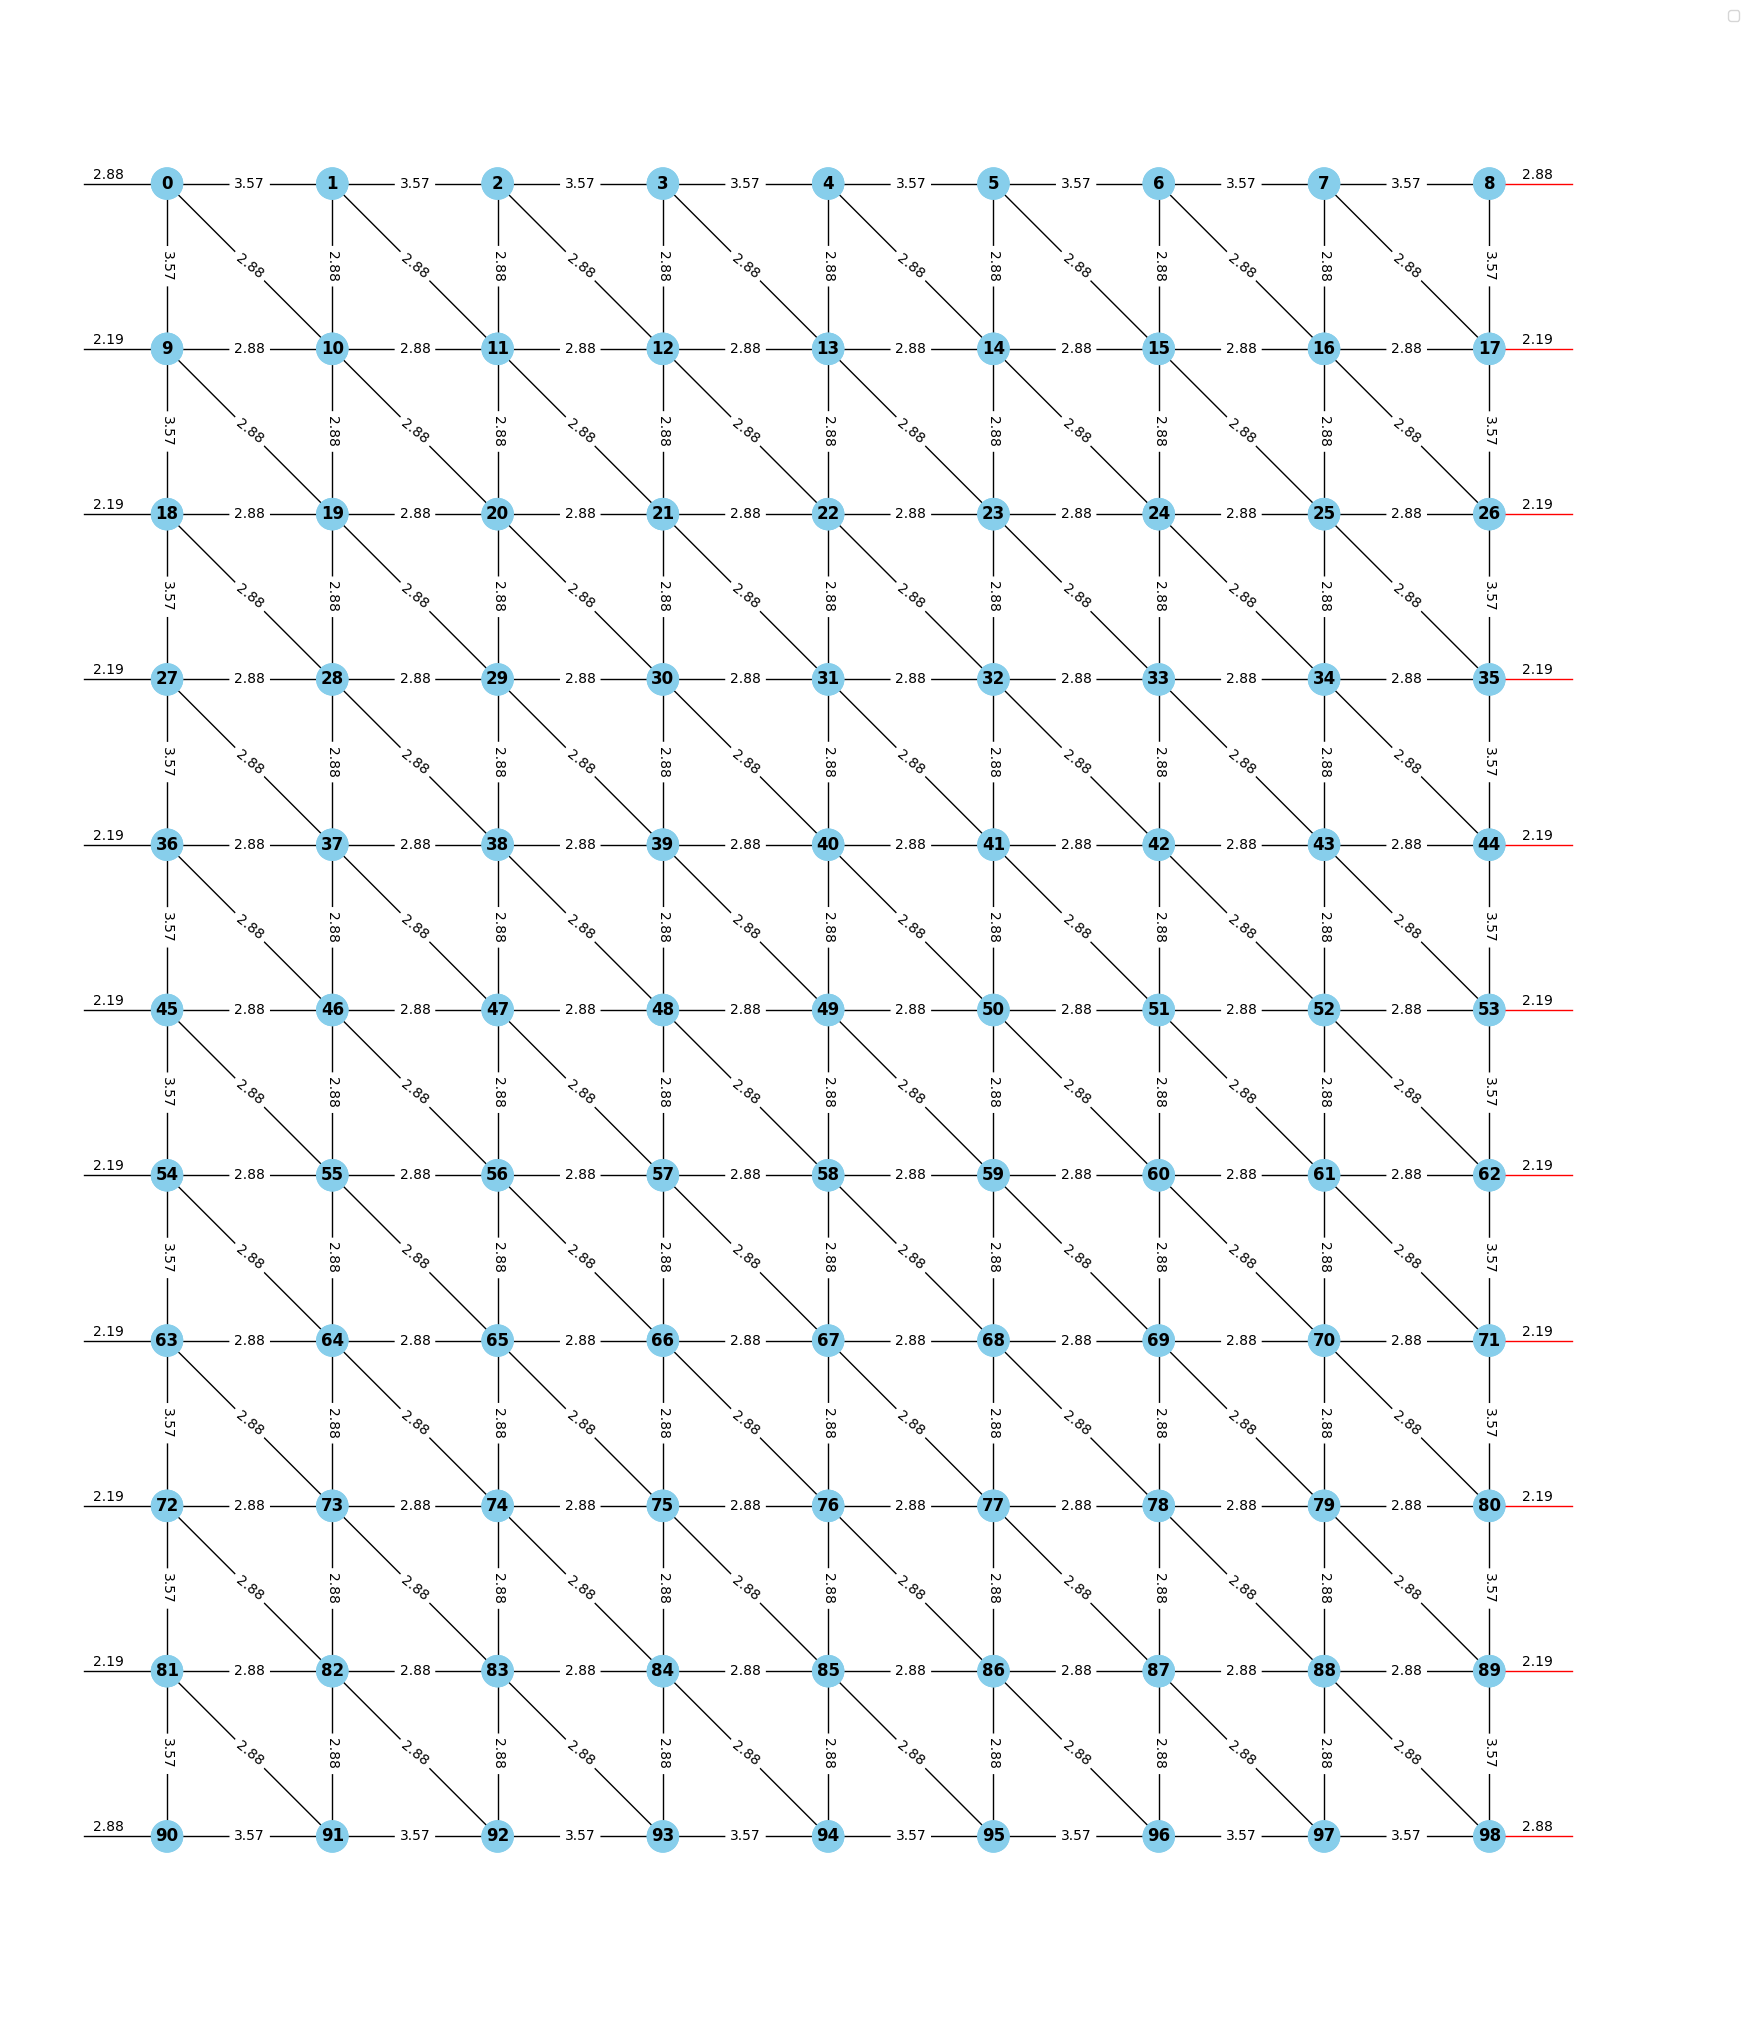

In [ ]:
draw_matching_graph(matching, d, T, figsize=(20, 20))

In [71]:
from tqdm import tqdm

from soft_info import counts_to_det_syndr, reweight_edges_to_one, soft_reweight_pymatching, draw_matching_graph, get_counts

VERBOSE = False

actual_observables = np.array([[False]]) # hardcoded, can be retrieved
num_errors = 0

i = 0
w_idx_lst = []
for shot in tqdm(range(len(memory))[:]):
    i += 1
    IQ_data = memory[shot]

    counts = get_counts([IQ_data], kde_dict, scaler_dict, layout, T, verbose=False)
    count_key = next(iter(counts.keys()))

    if count_key == '000 00 00 00':
        #print("Skipping all zeros")
        continue    

    soft_reweight_pymatching(matching, d, T, IQ_data, kde_dict, layout, scaler_dict, common_measure=0.01, verbose=False)  
    #reweight_edges_to_one(matching)

    array_processed_string = counts_to_det_syndr(count_key, verbose=False)

    predicted_observables = matching.decode(array_processed_string)

    num_errors += not np.array_equal(actual_observables[0, :], predicted_observables) # 0 can be changed to i if multiple observables and multiple syndromes per ovbservable


    if predicted_observables == [0]:
        continue

    print("Num errors:", num_errors)
    w_idx_lst.append(i)

    
    if VERBOSE:        
        print("Count key:", count_key)
        print("count str to syndromes:", array_processed_string)
        one_indices = np.where(array_processed_string == 1)[0].tolist()
        print("Indices with a '1':", one_indices)


    if VERBOSE:e
        matched_edges = matching.decode_to_edges_array(array_processed_string)
        print("matched_edges: ", matched_edges)
        print("Estimated flip:", predicted_observables)
        
    

    if VERBOSE:
        draw_matching_graph(matching, d, T, syndromes=array_processed_string, matched_edges=matched_edges, figsize=(30, 30))


    
print("Num errors:", num_errors)


  2%|▏         | 25/1111 [00:45<33:11,  1.83s/it]

Num errors: 1


  2%|▏         | 26/1111 [00:47<32:54,  1.82s/it]

Num errors: 2


  2%|▏         | 27/1111 [00:49<32:44,  1.81s/it]

Num errors: 3


  3%|▎         | 35/1111 [01:04<33:41,  1.88s/it]

Num errors: 4


  4%|▎         | 39/1111 [01:11<32:38,  1.83s/it]

Num errors: 5


  5%|▍         | 52/1111 [01:35<32:17,  1.83s/it]

Num errors: 6


  5%|▍         | 54/1111 [01:38<32:11,  1.83s/it]

Num errors: 7


  5%|▌         | 60/1111 [01:49<31:53,  1.82s/it]

Num errors: 8


  7%|▋         | 74/1111 [02:15<31:20,  1.81s/it]

Num errors: 9


  7%|▋         | 78/1111 [02:22<31:14,  1.82s/it]

Num errors: 10


  7%|▋         | 82/1111 [02:30<31:10,  1.82s/it]

Num errors: 11


  8%|▊         | 87/1111 [02:39<32:09,  1.88s/it]

Num errors: 12


  8%|▊         | 92/1111 [02:48<31:57,  1.88s/it]

Num errors: 13


  9%|▉         | 102/1111 [03:07<31:26,  1.87s/it]

Num errors: 14


  9%|▉         | 105/1111 [03:13<32:05,  1.91s/it]

Num errors: 15


 10%|█         | 116/1111 [03:33<30:50,  1.86s/it]

Num errors: 16


 11%|█         | 119/1111 [03:39<30:28,  1.84s/it]

Num errors: 17


 11%|█         | 122/1111 [03:44<30:13,  1.83s/it]

Num errors: 18


 12%|█▏        | 131/1111 [04:01<30:08,  1.85s/it]


KeyboardInterrupt: 